Reference to : https://medium.com/@yulongtsai/https-medium-com-yulongtsai-titanic-top3-8e64741cc11f

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier #Random Forest

In [2]:
#load data
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_data = df_train.append(df_test)
#df_data.info()

In [3]:
def check_dist(df, col_name):
    '''
    given the dataset and column name,
    print out the data distribution.
    '''
    for name in df[col_name].unique():
        print("{} distribute: {}".format(str(col_name)+'_'+str(name),
                                        len(df[df[col_name] == name]) / len(df)))
#check_dist(df_train, 'Sex')

In [4]:
def check_survive(df, col_name):
    '''
    given the dataset and column name,
    print out the survival percentage.
    '''
    for name in df[col_name].unique():
        print("{} survival: {}".format(str(col_name) + '_' + str(name),
                                       len(df[(df[col_name] == name) & (df['Survived'] == 1)]) / 
                                           len(df[df[col_name] == name])))

### Overall Survival Percentage

In [5]:
len(df_train[df_train['Survived'] == 1]) / len(df_train)

0.3838383838383838

### Gender

Sex_male distribute: 0.6475869809203143
Sex_female distribute: 0.35241301907968575
Sex_male survival: 0.18890814558058924
Sex_female survival: 0.7420382165605095


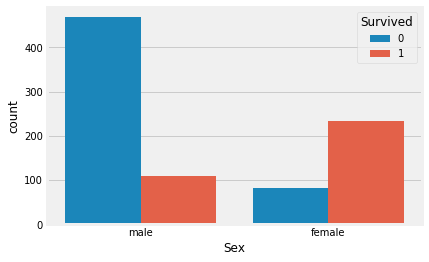

In [6]:
sns.countplot(df_train['Sex'], hue = df_train['Survived'])
check_dist(df_train, 'Sex')
check_survive(df_train, 'Sex')

From the training set I find that females are less than males, while females have much higher surviving rate.
How about test set?

In [7]:
check_dist(df_test, 'Sex')

Sex_male distribute: 0.6363636363636364
Sex_female distribute: 0.36363636363636365


Kind of the same distribution.

### Class

Pclass_3 distribute: 0.5510662177328844
Pclass_1 distribute: 0.24242424242424243
Pclass_2 distribute: 0.20650953984287318
Pclass_3 survival: 0.24236252545824846
Pclass_1 survival: 0.6296296296296297
Pclass_2 survival: 0.47282608695652173


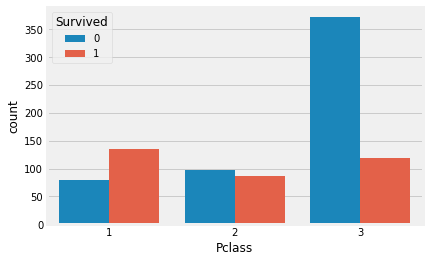

In [8]:
sns.countplot(df_train['Pclass'], hue = df_train['Survived'])
check_dist(df_train, 'Pclass')
check_survive(df_train, 'Pclass')

In [9]:
check_dist(df_test, 'Pclass')

Pclass_3 distribute: 0.5215311004784688
Pclass_2 distribute: 0.22248803827751196
Pclass_1 distribute: 0.25598086124401914


The training data show that the pclass item has a roughly linear relationship with the survival.

In [10]:
#convert the sex code
df_train['Sex'] = df_train['Sex'].map({'female': 1, 'male': 0}).astype(int)
df_test['Sex'] = df_test['Sex'].map({'female': 1, 'male': 0}).astype(int)
df_data['Sex'] = df_data['Sex'].map({'female': 1, 'male': 0}).astype(int)

In [11]:
#train a baseline model with RF
train_X = df_train.drop(['Survived', 'PassengerId'], axis = 1)
train_y = df_train['Survived']
baseline = ['Sex', 'Pclass']

rf_model = RandomForestClassifier(random_state = 2000, n_estimators = 250, min_samples_split = 20, oob_score = True)
rf_model.fit(train_X[baseline], train_y)
print(rf_model.oob_score_)

0.7474747474747475


In [12]:
#submit baseline prediction
output = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": rf_model.predict(df_test[baseline])})
output.to_csv('output.csv', index = False)

## Accuracy baseline: 0.75598

### Fare
Since fare varies widely, it might be more reasonable to reform it with log.

Fare        
Survived      0       1
Pclass                 
1         44.75  77.958
2         13.00  21.000
3          8.05   8.517

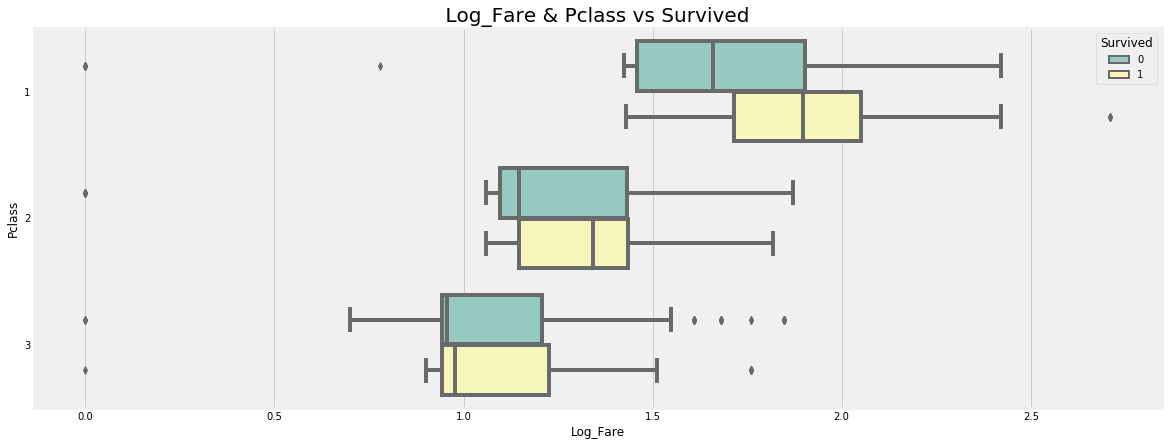

In [13]:
# there is some bugs in log-scale of boxplot. 
# alternatively, we transform x into log10(x) for visualization.
fig, ax = plt.subplots( figsize = (18,7) )
df_train['Log_Fare'] = (df_train['Fare']+1).map(lambda x : np.log10(x) if x > 0 else 0)
sns.boxplot(y='Pclass', x='Log_Fare', hue='Survived', data=df_train, orient='h',
            ax=ax, palette="Set3")
ax.set_title(' Log_Fare & Pclass vs Survived ',fontsize = 20)
pd.pivot_table(df_train, values = ['Fare'], index = ['Pclass'], columns= ['Survived'] ,aggfunc = 'median' ).round(3)

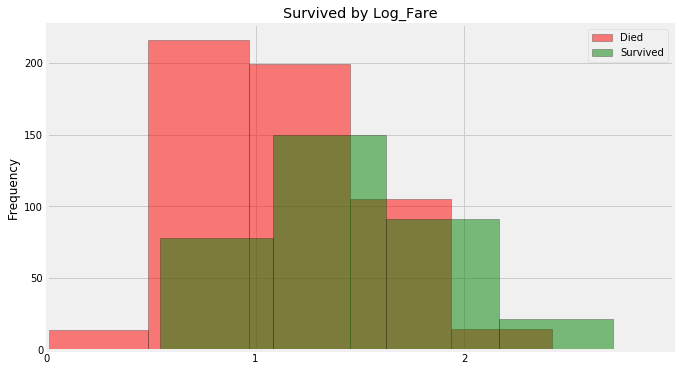

In [14]:
f, ax=plt.subplots(figsize=(10,6))
df_train[df_train['Survived']==0].Log_Fare.plot.hist(bins=5,edgecolor='black',color = 'red',
                                                     alpha = 0.5, label = 'Died')
df_train[df_train['Survived']==1].Log_Fare.plot.hist(color='green',bins=5,edgecolor='black', 
                                                     alpha = 0.5, label = 'Survived')
ax.set_xlim(0,3)
x1=list(range(0,3))
ax.set_xticks(x1)
ax.set_title('Survived by Log_Fare')
ax.legend(loc = 'best')
plt.show()

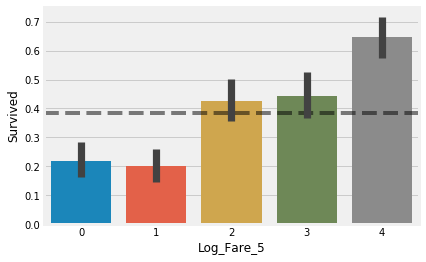

In [15]:
# fill the empty fare data with median in the whole dataset(train + test)
df_data['Fare'].fillna(df_data['Fare'].median(), inplace = True)

#create log_fare column
df_data['Log_Fare'] = (df_data['Fare']+1).map(lambda x : np.log10(x) if x > 0 else 0)

#make bins with log_fare
df_data['Log_Fare_5'] = pd.qcut(df_data['Log_Fare'], 5)

#import labelencoder
from sklearn.preprocessing import LabelEncoder

#set labelencoder and fit_transform
label = LabelEncoder()
df_data['Log_Fare_5'] = label.fit_transform(df_data['Log_Fare_5'])

#compare the fare intervals and survival percentage
_, ax = plt.subplots()
ax.axhline(0.384, linestyle='dashed', c='black',alpha = .5)
sns.factorplot(x='Log_Fare_5', y="Survived", data=df_data, kind='bar', ax = ax)
plt.close()

In [16]:
#try update kaggle and see how it goes
def run_rf(df_data, features, df_train = df_train, df_test = df_test, random_seed = 5566, debug = False):
    '''
    train dataset with RandomForestClassifier with given features,
    return prediction with data in test dataset.
    '''
    #separate df_data
    df_train = df_data[:len(df_train)]
    if debug:
        print(df_train.tail(2))
    df_test = df_data[len(df_train):]
    #set rf model
    rf_model = RandomForestClassifier(random_state = random_seed, n_estimators = 250, 
                                      min_samples_split = 20, oob_score = True)
    train_y = df_train['Survived']
    rf_model.fit(df_train[features], train_y)
    if debug:
        print(rf_model.oob_score_)
    return rf_model.predict(df_test[features])

prediction = run_rf(df_data, ['Sex','Pclass','Log_Fare_5'], debug = True)

      Age Cabin Embarked   Fare                   Name  Parch  PassengerId  \
889  26.0  C148        C  30.00  Behr, Mr. Karl Howell      0          890   
890  32.0   NaN        Q   7.75    Dooley, Mr. Patrick      0          891   

     Pclass  Sex  SibSp  Survived  Ticket  Log_Fare  Log_Fare_5  
889       1    0      0       1.0  111369  1.491362           3  
890       3    0      0       0.0  370376  0.942008           0  
0.8103254769921436


In [17]:
#submit
output = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": prediction.astype(int)})
output.to_csv('output.csv', index = False)

## Accuracy: 0.79425 nicely done

### Age

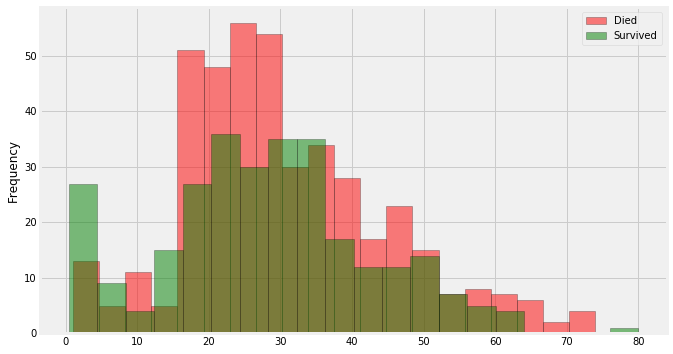

In [18]:
#check how age has impact on suvival
f, ax=plt.subplots(figsize=(10,6))
df_train[df_train['Survived']==0].Age.plot.hist(bins=20,edgecolor='black',color = 'red',
                                                     alpha = 0.5, label = 'Died')
df_train[df_train['Survived']==1].Age.plot.hist(color='green',bins=20,edgecolor='black', 
                                                     alpha = 0.5, label = 'Survived')
ax.legend(loc = 'best')

It seems like children have extremely high chance to survive from the tragedy! But age in other ranges might not have higher chance to survive.

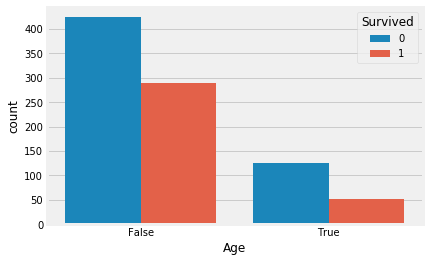

In [19]:
#check how nan in age has impact on suvival
sns.countplot(df_train['Age'].isna(), hue = df_train['Survived'])

In [20]:
#create child feature
df_data['child'] = df_data['Age'] <= 8
df_data['youth'] = (df_data['Age'] > 8) & (df_data['Age'] <= 15)
print(len(df_data[(df_data['youth'] == True) & (df_data['Survived'] == 1)]) / 
      len(df_data[(df_data['youth'] == True) & (df_data['Survived'].isna() == False)]))

0.4482758620689655


In [21]:
df_data['Age_nan'] = df_data['Age'].isna()
len(df_train[(df_train['Age'].isna() == True) & (df_train['Survived'] == 1)]) / ( 
    len(df_train[(df_train['Age'].isna() == True) & (df_train['Survived'] == 0)]) +
    len(df_train[(df_train['Age'].isna() == True) & (df_train['Survived'] == 1)]))

0.2937853107344633

Nan values in Age and teenagers might have slight impact on the survival, but less than 10%.

In [22]:
prediction = run_rf(df_data, ['Sex','Pclass','Log_Fare_5','child','youth','Age_nan'], debug = False)

#submit
output = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": prediction.astype(int)})
output.to_csv('output.csv', index = False)

## 0.77033 Kind of Overfitting
Which means age might share the same survival factors with gender and pclass, but the data quality is lower.

### Ticket

In [23]:
df_data['Ticket'].describe()

count         1309
unique         929
top       CA. 2343
freq            11
Name: Ticket, dtype: object

In [24]:
#compute family size
df_data['family_size'] = df_data['SibSp'] + df_data['Parch'] + 1

In [25]:
#build the list of duplicate_tickets
duplicate_tickets = []
for tk in df_data['Ticket'].unique():
    temp = df_data.loc[df_data.Ticket == tk, 'Fare']
    if temp.count() > 1:
        duplicate_tickets.append(df_data.loc[df_data.Ticket == tk,
                                            ['Name','Ticket','Cabin','family_size','Survived',
                                             'Age', 'Sex', 'Pclass', 'Fare']])
duplicate_tickets = pd.concat(duplicate_tickets)
duplicate_tickets.head(20)

Name    Ticket Cabin  \
1    Cumings, Mrs. John Bradley (Florence Briggs Th...  PC 17599   C85   
234                          Cumings, Mr. John Bradley  PC 17599   C85   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)    113803  C123   
137                        Futrelle, Mr. Jacques Heath    113803  C123   
6                              McCarthy, Mr. Timothy J     17463   E46   
146                        Hilliard, Mr. Herbert Henry     17463   E46   
7                       Palsson, Master. Gosta Leonard    349909   NaN   
24                       Palsson, Miss. Torborg Danira    349909   NaN   
374                         Palsson, Miss. Stina Viola    349909   NaN   
567        Palsson, Mrs. Nils (Alma Cornelia Berglund)    349909   NaN   
389                        Palsson, Master. Paul Folke    349909   NaN   
8    Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)    347742   NaN   
172                       Johnson, Miss. Eleanor Ileen    347742   NaN   
869                    Johnson, Master. Harold Theodor    347742   NaN   
9                  Nasser, Mrs. Nicholas (Adele Achem)    237736   NaN   
122                               Nasser, Mr. Nicholas    237736   NaN   
10                     Sandstrom, Miss. Marguerite Rut   PP 9549    G6   
394  Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...   PP 9549    G6   
117                    Sandstrom, Miss. Beatrice Irene   PP 9549    G6   
13                         Andersson, Mr. Anders Johan    347082   NaN   

     family_size  Survived   Age  Sex  Pclass     Fare  
1              2       1.0  38.0    1       1  71.2833  
234            2       NaN  39.0    0       1  71.2833  
3              2       1.0  35.0    1       1  53.1000  
137            2       0.0  37.0    0       1  53.1000  
6              1       0.0  54.0    0       1  51.8625  
146            1       NaN   NaN    0       1  51.8625  
7              5       0.0   2.0    0       3  21.0750  
24             5       0.0   8.0    1       3  21.0750  
374            5       0.0   3.0    1       3  21.0750  
567            5       0.0  29.0    1       3  21.0750  
389            5       NaN   6.0    0       3  21.0750  
8              3       1.0  27.0    1       3  11.1333  
172            3       1.0   1.0    1       3  11.1333  
869            3       1.0   4.0    0       3  11.1333  
9              2       1.0  14.0    1       2  30.0708  
122            2       0.0  32.5    0       2  30.0708  
10             3       1.0   4.0    1       3  16.7000  
394            3       1.0  24.0    1       3  16.7000  
117            3       NaN   1.0    1       3  16.7000  
13             7       0.0  39.0    0       3  31.2750

In [26]:
len(duplicate_tickets)

596

In [27]:
# the same ticket family or friends
df_data['Connected_Survival'] = 0.5 # default 
for _, df_grp in df_data.groupby('Ticket'):
    if (len(df_grp) > 1):
        for idx, row in df_grp.iterrows():
            smax = df_grp.drop(idx)['Survived'].max()
            smin = df_grp.drop(idx)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                df_data.loc[df_data['PassengerId'] == passID, 'Connected_Survival'] = 1
            elif (smin==0.0):
                df_data.loc[df_data['PassengerId'] == passID, 'Connected_Survival'] = 0
#print
print('people keep the same ticket: %.0f '%len(duplicate_tickets))
print("people have connected information : %.0f" 
      %(df_data[df_data['Connected_Survival']!=0.5].shape[0]))
df_data.groupby('Connected_Survival')[['Survived']].mean().round(3)

people keep the same ticket: 596 
people have connected information : 496


Survived
Connected_Survival          
0.0                    0.225
0.5                    0.298
1.0                    0.728

In [28]:
#another try
prediction = run_rf(df_data, ['Sex','Pclass','Log_Fare_5','Connected_Survival'], debug = False)

#submit
output = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": prediction.astype(int)})
output.to_csv('output.csv', index = False)

## 0.80861 Very usful information!

In [29]:
#how about age info collaborate with ticket info?
prediction = run_rf(df_data, ['Sex','Pclass','Log_Fare_5','Connected_Survival', 'child','youth','Age_nan'],
                    debug = False)

#submit
output = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": prediction.astype(int)})
output.to_csv('output.csv', index = False)

## 0.80861 Same prediction?

In [30]:
#check how we can get age info from other data
df_data[df_data['Age_nan'] == True]

Age  Cabin Embarked      Fare  \
5    NaN    NaN        Q    8.4583   
17   NaN    NaN        S   13.0000   
19   NaN    NaN        C    7.2250   
26   NaN    NaN        C    7.2250   
28   NaN    NaN        Q    7.8792   
29   NaN    NaN        S    7.8958   
31   NaN    B78        C  146.5208   
32   NaN    NaN        Q    7.7500   
36   NaN    NaN        C    7.2292   
42   NaN    NaN        C    7.8958   
45   NaN    NaN        S    8.0500   
46   NaN    NaN        Q   15.5000   
47   NaN    NaN        Q    7.7500   
48   NaN    NaN        C   21.6792   
55   NaN    C52        S   35.5000   
64   NaN    NaN        C   27.7208   
65   NaN    NaN        C   15.2458   
76   NaN    NaN        S    7.8958   
77   NaN    NaN        S    8.0500   
82   NaN    NaN        Q    7.7875   
87   NaN    NaN        S    8.0500   
95   NaN    NaN        S    8.0500   
101  NaN    NaN        S    7.8958   
107  NaN    NaN        S    7.7750   
109  NaN    NaN        Q   24.1500   
121  NaN    NaN        S    8.0500   
126  NaN    NaN        Q    7.7500   
128  NaN  F E69        C   22.3583   
140  NaN    NaN        C   15.2458   
154  NaN    NaN        S    7.3125   
..   ...    ...      ...       ...   
268  NaN    NaN        S    8.0500   
271  NaN    NaN        Q    7.7500   
273  NaN    NaN        Q   15.5000   
274  NaN    NaN        C    7.2250   
282  NaN    NaN        Q    7.7500   
286  NaN    NaN        S    7.2500   
288  NaN  F E46        C    7.2292   
289  NaN    NaN        S    8.0500   
290  NaN    NaN        S   39.6000   
292  NaN    NaN        C    7.2292   
297  NaN    NaN        C   21.6792   
301  NaN      D        C   15.0458   
304  NaN    NaN        Q    7.7500   
312  NaN    NaN        S    7.5750   
332  NaN    NaN        C    7.2250   
339  NaN    NaN        C    7.2292   
342  NaN    NaN        S   69.5500   
344  NaN    NaN        S   14.5000   
357  NaN    NaN        S    7.8792   
358  NaN    NaN        Q    7.7500   
365  NaN    NaN        S   69.5500   
366  NaN    NaN        C   14.4583   
380  NaN    NaN        Q    7.7500   
382  NaN    NaN        S   14.5000   
384  NaN    NaN        S   12.8750   
408  NaN    NaN        Q    7.7208   
410  NaN    NaN        Q    7.7500   
413  NaN    NaN        S    8.0500   
416  NaN    NaN        S    8.0500   
417  NaN    NaN        C   22.3583   

                                               Name  Parch  PassengerId  \
5                                  Moran, Mr. James      0            6   
17                     Williams, Mr. Charles Eugene      0           18   
19                          Masselmani, Mrs. Fatima      0           20   
26                          Emir, Mr. Farred Chehab      0           27   
28                    O'Dwyer, Miss. Ellen "Nellie"      0           29   
29                              Todoroff, Mr. Lalio      0           30   
31   Spencer, Mrs. William Augustus (Marie Eugenie)      0           32   
32                         Glynn, Miss. Mary Agatha      0           33   
36                                 Mamee, Mr. Hanna      0           37   
42                              Kraeff, Mr. Theodor      0           43   
45                         Rogers, Mr. William John      0           46   
46                                Lennon, Mr. Denis      0           47   
47                        O'Driscoll, Miss. Bridget      0           48   
48                              Samaan, Mr. Youssef      0           49   
55                                Woolner, Mr. Hugh      0           56   
64                            Stewart, Mr. Albert A      0           65   
65                         Moubarek, Master. Gerios      1           66   
76                                Staneff, Mr. Ivan      0           77   
77                         Moutal, Mr. Rahamin Haim      0           78   
82                   McDermott, Miss. Brigdet Delia      0           83   
87                    Slocovski, Mr. Selman Francis      0           88  

In [31]:
#Maybe we can fill age with the info in name column?!
df_data['Initial']=0
for i in df_data:
    df_data['Initial']=df_data.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations

In [32]:
#check if every name has an initial item
df_data['Initial'].isna().sum()
#0 great!

0

Since every name has an initial item, now we can try to dig in to the initial and try to find out more information.

In [33]:
pd.crosstab(df_data.Initial, [df_data.Sex, df_data.Pclass]).T.style.background_gradient(cmap='summer_r') #Checking the Initials with the Sex

In [34]:
pd.crosstab(df_data.Initial, [df_data.Sex, df_data.Survived]).T.style.background_gradient(cmap='summer_r')

Okay so there are some misspelled Initials like Mlle or Mme that stand for Miss. I will replace them with Miss and same thing for other values. Capt is the only one captain on Titanic.

In [35]:
df_data['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer',
                            'Col','Rev','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Other','Other','Other','Other','Other',
                         'Other','Other','Other','Other', 'Other'],
                        inplace=True)

In [36]:
df_data['Initial'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Other', 'Capt'], dtype=object)

In [37]:
df_data.groupby('Initial')['Age'].median() #lets check the average age by Initials

Initial
Capt      70.0
Master     4.0
Miss      22.0
Mr        29.0
Mrs       35.5
Other     47.0
Name: Age, dtype: float64

In [38]:
#now fill empty ages with the median age of the inital groups
def fill_nan_age(df):
    median_age = df.groupby('Initial')['Age'].median()
    for initial in df['Initial'].unique():
        df.loc[(df.Age.isnull())&(df.Initial==initial),'Age']=median_age[initial]
    return df
df_data = fill_nan_age(df_data)

In [39]:
df_data['Age'].isna().sum()

0

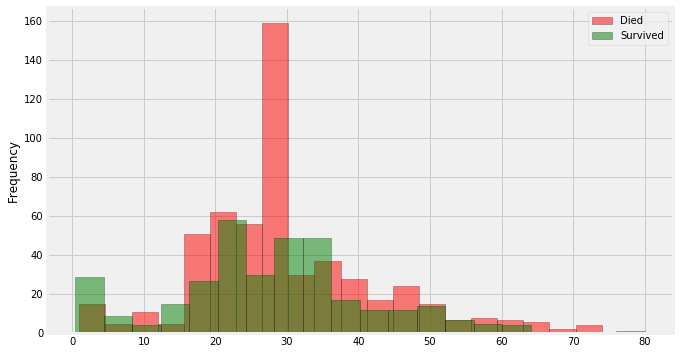

In [40]:
#check how age has impact on suvival
f, ax=plt.subplots(figsize=(10,6))
df_data[df_data['Survived']==0].Age.plot.hist(bins=20,edgecolor='black',color = 'red',
                                                     alpha = 0.5, label = 'Died')
df_data[df_data['Survived']==1].Age.plot.hist(color='green',bins=20,edgecolor='black', 
                                                     alpha = 0.5, label = 'Survived')
ax.legend(loc = 'best')

In [41]:
#create child feature
df_data['child'] = df_data['Age'] <= 8
df_data['youth'] = (df_data['Age'] > 8) & (df_data['Age'] <= 16)
print(len(df_data[(df_data['child'] == True) & (df_data['Survived'] == 1)]) / 
      len(df_data[(df_data['child'] == True) & (df_data['Survived'].isna() == False)]))
print(len(df_data[(df_data['youth'] == True) & (df_data['Survived'] == 1)]) / 
      len(df_data[(df_data['youth'] == True) & (df_data['Survived'].isna() == False)]))

0.6551724137931034
0.41304347826086957


In [42]:
#how about age info collaborate with ticket info?
prediction = run_rf(df_data, ['Sex','Pclass','Log_Fare_5','Connected_Survival', 'child','youth'],
                    debug = False)

#submit
output = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": prediction.astype(int)})
output.to_csv('output.csv', index = False)

## 0.81818~0.82296 Improved! 
Note that although I originally set the youth label between 8 and 15 ages old and get higher survival percentage than 8 to 16, but actually the range between 8 and 16 gets better prediction accuracy on the test set.

### Embark

In [43]:
def get_embarked_pos(df):
    df_data_index = df.reset_index(drop = True)
    #df_data_index.tail()
    embarked = pd.get_dummies(df_data_index.Embarked, drop_first = True).astype(int)
    
    #df.drop(['Embarked'], axis = 1, inplace = True)
    return df_data_index.join(embarked)

#fillna with most embarked position
df_data.loc[df_data.Embarked.isna(), 'Embarked'] = 'S'
pd.crosstab([df_data.Embarked,df_data.Pclass],
            [df_data.Log_Fare_5],margins=True).style.background_gradient(cmap='summer_r')

In [44]:
df_data = get_embarked_pos(df_data)

In [45]:
prediction = run_rf(df_data, ['Sex','Pclass','Log_Fare_5','Connected_Survival', 'child','youth', 'Q', 'S'],
                    debug = False)

#submit
output = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": prediction.astype(int)})
output.to_csv('output.csv', index = False)

## 0.80861 no better!

### Cabin

In [46]:
#df_data = df_data.reset_index(drop = True)
#df_data.drop(['has_cabin'],axis = 1, inplace = True)
df_data['no_cabin'] = df_data.Cabin.isna() #many nan values
df_data.loc[df_data['no_cabin'] == False, 'Cabin'] = df_data[df_data['no_cabin'] == False]['Cabin'].str[0]

In [47]:
pd.crosstab([df_data.no_cabin, df_data.Survived], [df_data.Embarked],
            margins=True).style.background_gradient(cmap='summer_r')

In [48]:
df_data['Cabin'].unique()

array([nan, 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [49]:
pd.crosstab([df_data.Cabin, df_data.Survived], [df_data.child, df_data.youth],
            margins=True).style.background_gradient(cmap='summer_r')

Looks like cabin locations have heavy impacts on the survival.

In [50]:
prediction = run_rf(df_data, ['Sex','Pclass','Log_Fare_5','Connected_Survival', 'child','youth', 
                              'no_cabin'],
                    debug = False)

#submit
output = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": prediction.astype(int)})
output.to_csv('output.csv', index = False)

## 0.82296 Same

Since it's a very tiny dataset, it can easily get overfitting. I think the data engineering is done enough for it. To get better prediction, we might need to ensemble different models.